In [62]:
import local_models.local_models as lm
import numpy as np
import matplotlib.pyplot as plt
import sklearn.linear_model
import sklearn.cluster
from importlib import reload
from ml_battery.utils import cmap
import matplotlib as mpl
import sklearn.datasets
import sklearn.decomposition
import logging
import ml_battery.log
import time
import os
import local_models.loggin
import local_models.TLS_models
import local_models.algorithms
import local_models.linear_projections

logger = logging.getLogger(__name__)

np.random.seed(1)
reload(local_models.local_models)
reload(lm)
#reload(local_models.loggin)
#reload(local_models.TLS_models)
np.warnings.filterwarnings('ignore')


In [4]:
mpl.rcParams['figure.figsize'] = [8.0, 8.0]

In [5]:
n = 200
K=14
noise=0.04
factor = 0.3
SEED = 1
np.random.seed(SEED)
KERNEL=local_models.local_models.GaussianKernel
noisy_circles, c = sklearn.datasets.make_circles(n_samples=n, factor=factor,
                                      noise=noise)

In [ ]:
project_dir = "../data/squares"
os.makedirs(project_dir, exist_ok=1)

In [42]:
def create_noisy_rectangle(h,w,theta,sigma,n):
    top_bottom_n = int(n/(2*(h/w+1)))
    sides_n = int(n/(2*(w/h+1)))
    top_bottom_zeros = np.zeros(top_bottom_n)
    sides_zeros = np.zeros(sides_n)

    top = np.stack((np.random.uniform(0,w,top_bottom_n), top_bottom_zeros + h))
    top_noise = np.stack((top_bottom_zeros, np.random.normal(0,sigma,top_bottom_n)))
    top += top_noise
    
    bottom = np.stack((np.random.uniform(0,w,top_bottom_n), top_bottom_zeros))
    bottom_noise = np.stack((top_bottom_zeros, np.random.normal(0,sigma,top_bottom_n)))
    bottom += bottom_noise
    
    left = np.stack((sides_zeros, np.random.uniform(0,h,sides_n)))
    left_noise = np.stack((np.random.normal(0,sigma,sides_n), sides_zeros))
    left += left_noise
    
    right = np.stack((sides_zeros + w, np.random.uniform(0,h,sides_n)))
    right_noise = np.stack((np.random.normal(0,sigma,sides_n), sides_zeros))
    right += right_noise
    
    print(top.shape, bottom.shape, left.shape, right.shape)
    
    rect = np.concatenate((top.T,left.T,bottom.T,right.T))
    return rect.dot(np.array([[np.cos(theta), -np.sin(theta)],[np.sin(theta), np.cos(theta)]]))

In [43]:
noisy_rect = create_noisy_rectangle(2,1,np.pi/6,0.02,400)

(2, 66) (2, 66) (2, 133) (2, 133)


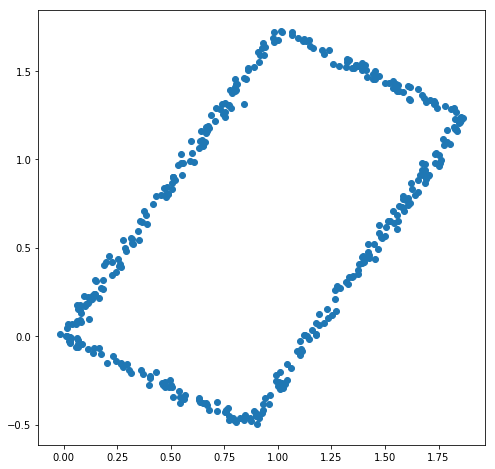

In [44]:
plt.scatter(noisy_rect[:,0], noisy_rect[:,1])
plt.show()

In [70]:
KERNEL = lm.GaussianKernel
kernel = lm.GaussianKernel(bandwidth=0.2)
linear_models = lm.LocalModels(local_models.TLS_models.LinearODR_mD(1))
linear_models.fit(noisy_rect)

In [51]:
linear_params = linear_models.transform(noisy_rect,r=kernel.support_radius(),weighted=True,distance_transform=kernel)

In [52]:
linear_params.shape

(398, 4)

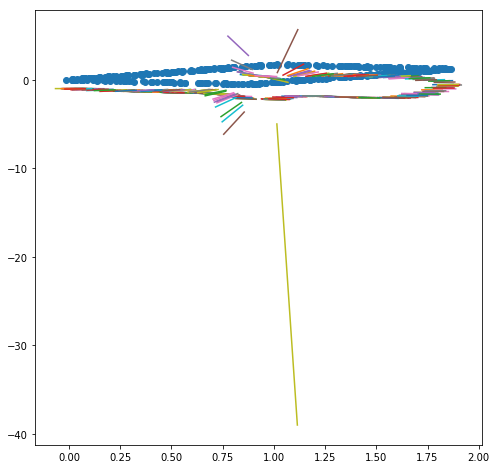

In [53]:
plt.scatter(noisy_rect[:,0], noisy_rect[:,1])
span = np.linspace(-0.05,0.05,10)
for i in range(noisy_rect.shape[0]):
    x,y = noisy_rect[i]
    plt.plot(span + x, (1-linear_params[i,0]*(span+x))/linear_params[i,1])
#plt.xlim(0,0.8)
#plt.ylim(-.8,0)
plt.show()

In [54]:
RANGE_PCT = 0.1
data = noisy_rect
min_data, max_data = np.min(data, axis=0), np.max(data, axis=0)
data_range = max_data - min_data
how_much_to_include_outside_range = RANGE_PCT*data_range
data_ranges = np.stack((min_data - how_much_to_include_outside_range, max_data + how_much_to_include_outside_range)).T
data_step = ((data_ranges[:,1] - data_ranges[:,0])/100)
grid_limits = tuple(map(lambda i: slice(data_ranges[i][0], data_ranges[i][1], data_step[i]), range(data_ranges.shape[0])))
g = np.mgrid[grid_limits]
xx = np.vstack(map(np.ravel, g)).T
g_like_shape = [-1] + list(g.shape[1:])



In [55]:
xx_linear_params = linear_models.transform(xx,r=kernel.support_radius(),weighted=True,distance_transform=kernel)
xx_linear_params.shape

(10000, 4)

In [56]:
projected_xx = np.zeros(xx.shape)
for i in range(len(xx_linear_params)):
    lr = local_models.TLS_models.LinearODR_mD(1)
    lr.coef_ = xx_linear_params[i,:2]
    lr.cov_eigenvectors = xx_linear_params[i].reshape(2,2)
    lr.cov_eigenvalues_sorter = [1,2]
    lr.intercept_ = xx_linear_params[i,2:]
    projected_xx[i] = lr.project(xx[i:i+1]) - xx[i:i+1]
    

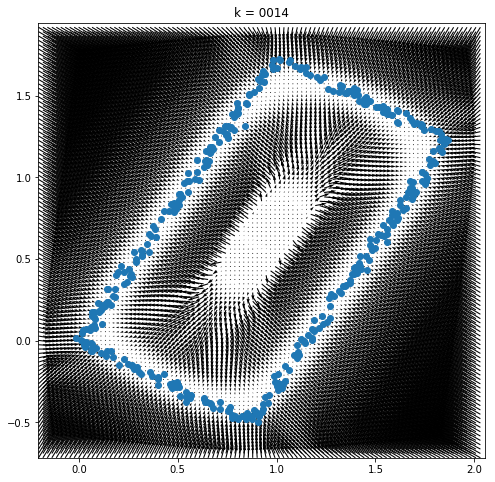

In [59]:
changes = projected_xx
pts = np.array([[1.8, 0.1]])
plt.quiver(xx[:,0], xx[:,1], changes[:,0], changes[:,1], scale=10)
plt.scatter(noisy_rect[:,0], noisy_rect[:,1])
plt.xlim(*data_ranges[0])
plt.ylim(*data_ranges[1])
plt.title("k = {:04d}".format(K))

span = np.linspace(0.05,0.07,10)
pts_params = linear_models.transform(pts, k=K, weighted=True, distance_transform=kernel)
for i in range(pts.shape[0]):
    x,y = pts[i]
    plt.plot(span + x, (1-pts_params[i,0]*(span+x))/pts_params[i,1])
plt.savefig(os.path.join(project_dir, "k_{:04d}.png".format(K)))
plt.show()

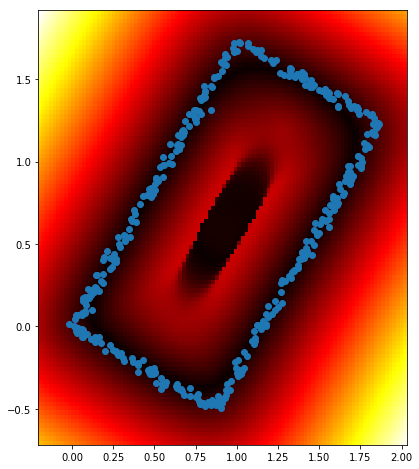

In [60]:
change_norm = np.linalg.norm(changes,axis=1,keepdims=True)
change_norm_unraveled = change_norm.T.reshape((-1,int(change_norm.shape[0]**0.5),int(change_norm.shape[0]**0.5)))
plt.imshow(change_norm_unraveled[0].T, cmap='hot', interpolation='nearest', extent=[min(xx[:,0]), max(xx[:,0]), min(xx[:,1]), max(xx[:,1])], origin='lower')
plt.scatter(noisy_rect[:,0], noisy_rect[:,1])
plt.show()

In [73]:
bandwidth = 0.1
data = noisy_rect
range_pct = 0.1
kernel = KERNEL(bandwidth=bandwidth)
grid_steps = 100

data_mins, data_maxes, data_ranges = local_models.linear_projections.min_max_range(data)
graph_bounds = local_models.linear_projections.sane_graph_bounds(data_mins, data_maxes, data_ranges, range_pct)
spans = np.stack([(-0.02, 0.02, 2j) for i in range(linear_models.model.m)])

grid = local_models.utils.get_global_grid(noisy_rect, outside_range_pct=range_pct, n_steps=grid_steps)
gridder = local_models.utils.Grid2Vec()
grid = gridder.fit_transform(grid)
projections = grid.copy()

for tls_shifted in local_models.algorithms.local_tls_shift_till_convergence(linear_models, projections, kernel=kernel):
    pass

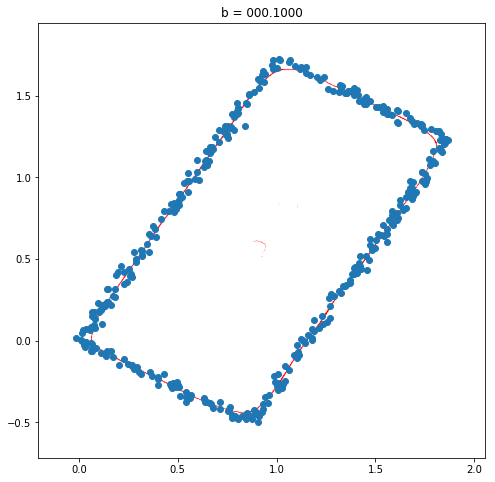

In [74]:
plt.scatter(tls_shifted[:,0],tls_shifted[:,1],c='r',s=0.01,marker='.')
#local_models.linear_projections.plt_local_odr_lines(lines)
plt.scatter(noisy_rect[:,0], noisy_rect[:,1])
local_models.linear_projections.plt_prettify("b = {:08.04f}".format(bandwidth), graph_bounds)
plt.savefig(os.path.join(project_dir, "bandwidth_{:08.04f}.png".format(bandwidth)))

In [75]:
thetas = np.arctan(linear_params[:,0]/linear_params[:,1])

In [78]:
thetas

array([-0.85793933, -1.04540429, -0.85424112, -0.25615568, -1.41826712,
       -0.79889872, -1.09819961, -0.94955965, -1.27753144, -0.58124167,
       -1.01813619, -1.20181316, -1.07457118, -0.87833634, -0.92694604,
       -0.14228729, -0.76172558,  1.37688302, -1.10845924, -0.89363379,
       -0.50651626, -1.4437851 , -0.66034894, -1.28565611, -0.75861264,
       -0.70142947, -1.11625488, -1.23680204, -0.88465663, -1.15113863,
       -0.26175208, -1.38449803, -0.50870976, -1.15863072, -1.00582629,
       -1.55015886, -0.7738411 , -0.22063032, -0.9505356 , -0.70879356,
       -1.01384116, -1.11064148, -1.14906798, -1.49025604, -1.08709628,
       -0.41718847, -1.03292635, -0.67183537, -1.36179676, -0.92605836,
       -0.91779465, -1.12613588, -1.23679793, -1.06453499, -0.87558881,
       -0.58796595, -1.35421254, -1.14156812,  1.56785587, -0.96070419,
       -0.91120412, -1.03223331, -0.72327585, -1.07775701, -1.40490859,
       -1.00507501,  0.62927744,  0.52476251,  0.62614615,  0.52

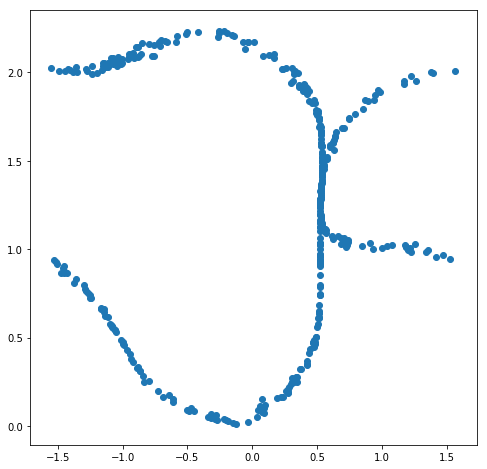

In [84]:
plt.scatter(thetas, np.linalg.norm(noisy_rect,axis=1))
plt.show()

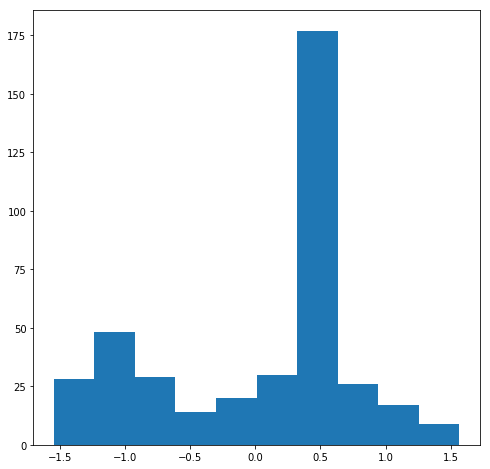

In [77]:
plt.hist(thetas)
plt.show()

In [92]:
blah = sklearn.cluster.KMeans(4).fit(np.concatenate((thetas.reshape(-1,1), noisy_rect), axis=1))

In [93]:
c = blah.predict(np.concatenate((thetas.reshape(-1,1), noisy_rect), axis=1))

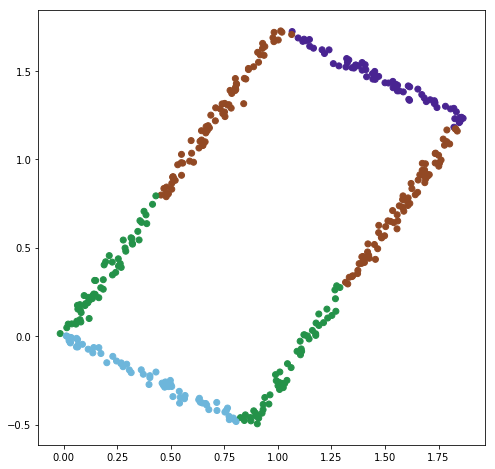

In [94]:
plt.scatter(noisy_rect[:,0], noisy_rect[:,1], c=cmap(c))